In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
import catboost as cb

C:\Games\anacondajup\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('MSFT_Stock_nan.csv', index_col=[0], parse_dates = [0])
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2001-03-16,26.25000,27.56250,26.24219,27.28125,112848800
NaT,27.25000,27.75000,26.56250,27.15625,61036400
2001-03-20,27.28125,28.06250,26.31250,26.34375,91822800
2001-03-21,26.12500,26.62500,24.87500,25.03125,124988600
2001-03-22,25.28125,27.03125,25.25000,27.00000,126363200
...,...,...,...,...,...
2021-01-25,229.12000,229.78000,224.22000,229.53000,33152095
2021-01-26,231.86000,234.17999,230.08000,232.33000,48699200
2021-01-27,238.00000,240.44000,230.14000,232.89999,69757500


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2001-03-16 to 2021-01-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5000 non-null   float64
 1   High    5000 non-null   float64
 2   Low     5000 non-null   float64
 3   Close   5000 non-null   float64
 4   Volume  5000 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 234.4 KB


In [4]:
df = df[df.index.notnull()]
df

,Open,High,Low,Close,Volume
Datetime,,,,,
2001-03-16,26.25000,27.56250,26.24219,27.28125,112848800
2001-03-20,27.28125,28.06250,26.31250,26.34375,91822800
2001-03-21,26.12500,26.62500,24.87500,25.03125,124988600
2001-03-22,25.28125,27.03125,25.25000,27.00000,126363200
2001-03-23,27.46875,28.50000,27.18750,28.28125,99519600
...,...,...,...,...,...
2021-01-25,229.12000,229.78000,224.22000,229.53000,33152095
2021-01-26,231.86000,234.17999,230.08000,232.33000,48699200
2021-01-27,238.00000,240.44000,230.14000,232.89999,69757500


In [5]:
df.index.is_monotonic

True

In [6]:
df.index = pd.to_datetime(df.index)
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [7]:
df = df.resample('M').agg({'Open': 'mean', 'High': 'max', 'Low': 'min', 'Close': 'mean', 'Volume': 'sum'})
print(df, df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 239 entries, 2001-03-31 to 2021-01-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    239 non-null    float64
 1   High    239 non-null    float64
 2   Low     239 non-null    float64
 3   Close   239 non-null    float64
 4   Volume  239 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 11.2 KB
                  Open       High        Low       Close      Volume
Datetime                                                            
2001-03-31   27.325000   29.28125   24.87500   27.390625   970665400
2001-04-30   30.828553   35.50000   25.53125   31.009013  1882887400
2001-05-31   34.883500   36.07500   33.66500   34.943250  1616017800
2001-06-30   35.158333   38.07500   33.00500   35.307381  1449177800
2001-07-31   34.260526   36.57500   32.10000   34.144737  1332928400
...                ...        ...        ...         ...         ...
2020-09

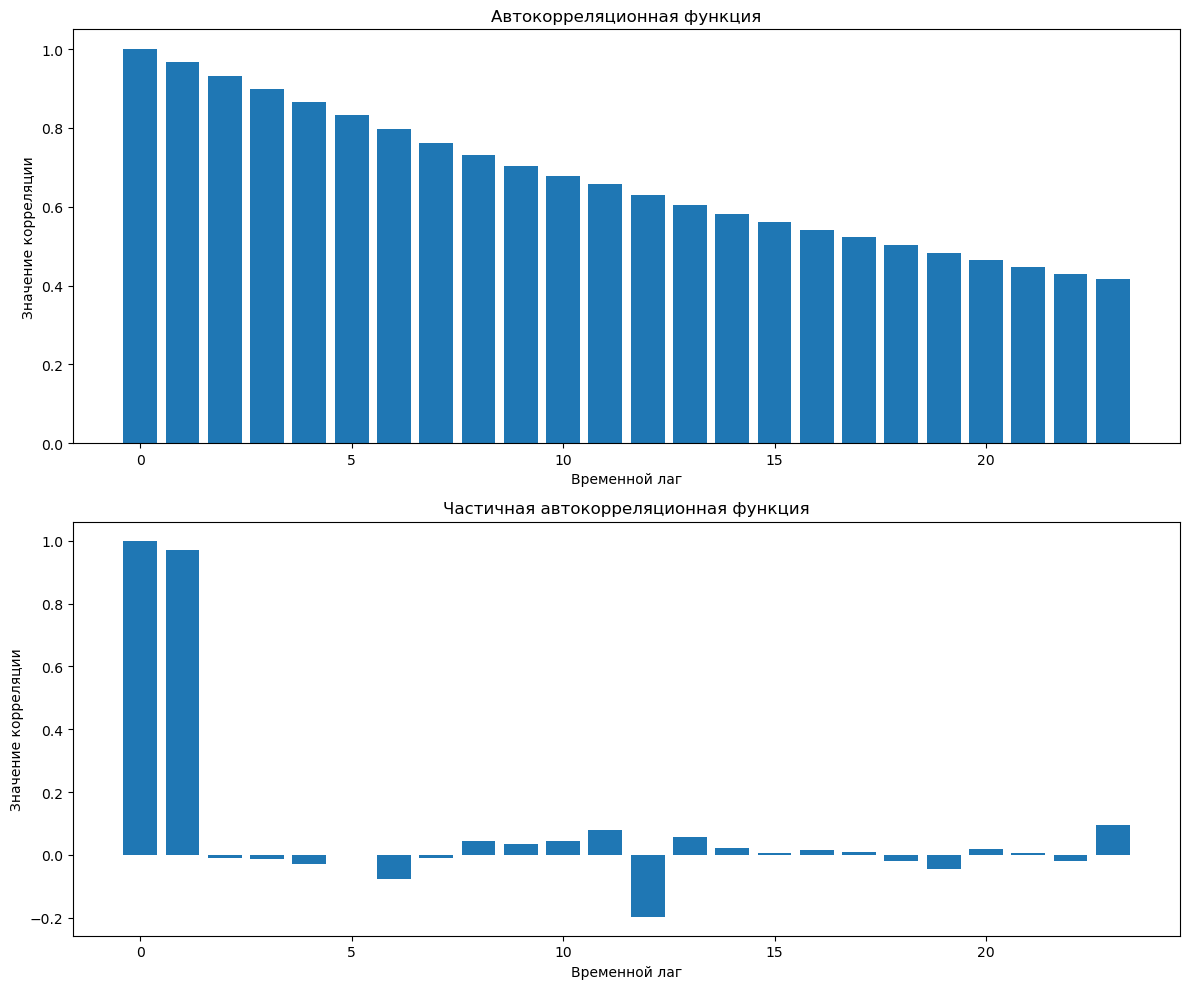

In [25]:
# Рассчитываем автокорреляцию данных
acf = sm.tsa.acf(df['Close'])

# Рассчитываем частичную автокорреляцию данных
pacf = sm.tsa.pacf(df['Close'])

# Отрисовка графиков автокорреляции и частичной автокорреляции
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.bar(range(len(acf)), acf)
plt.title('Автокорреляционная функция')
plt.xlabel('Временной лаг')
plt.ylabel('Значение корреляции')

plt.subplot(2,1,2)
plt.bar(range(len(pacf)), pacf)
plt.title('Частичная автокорреляционная функция')
plt.xlabel('Временной лаг')
plt.ylabel('Значение корреляции')

plt.tight_layout()
plt.show()

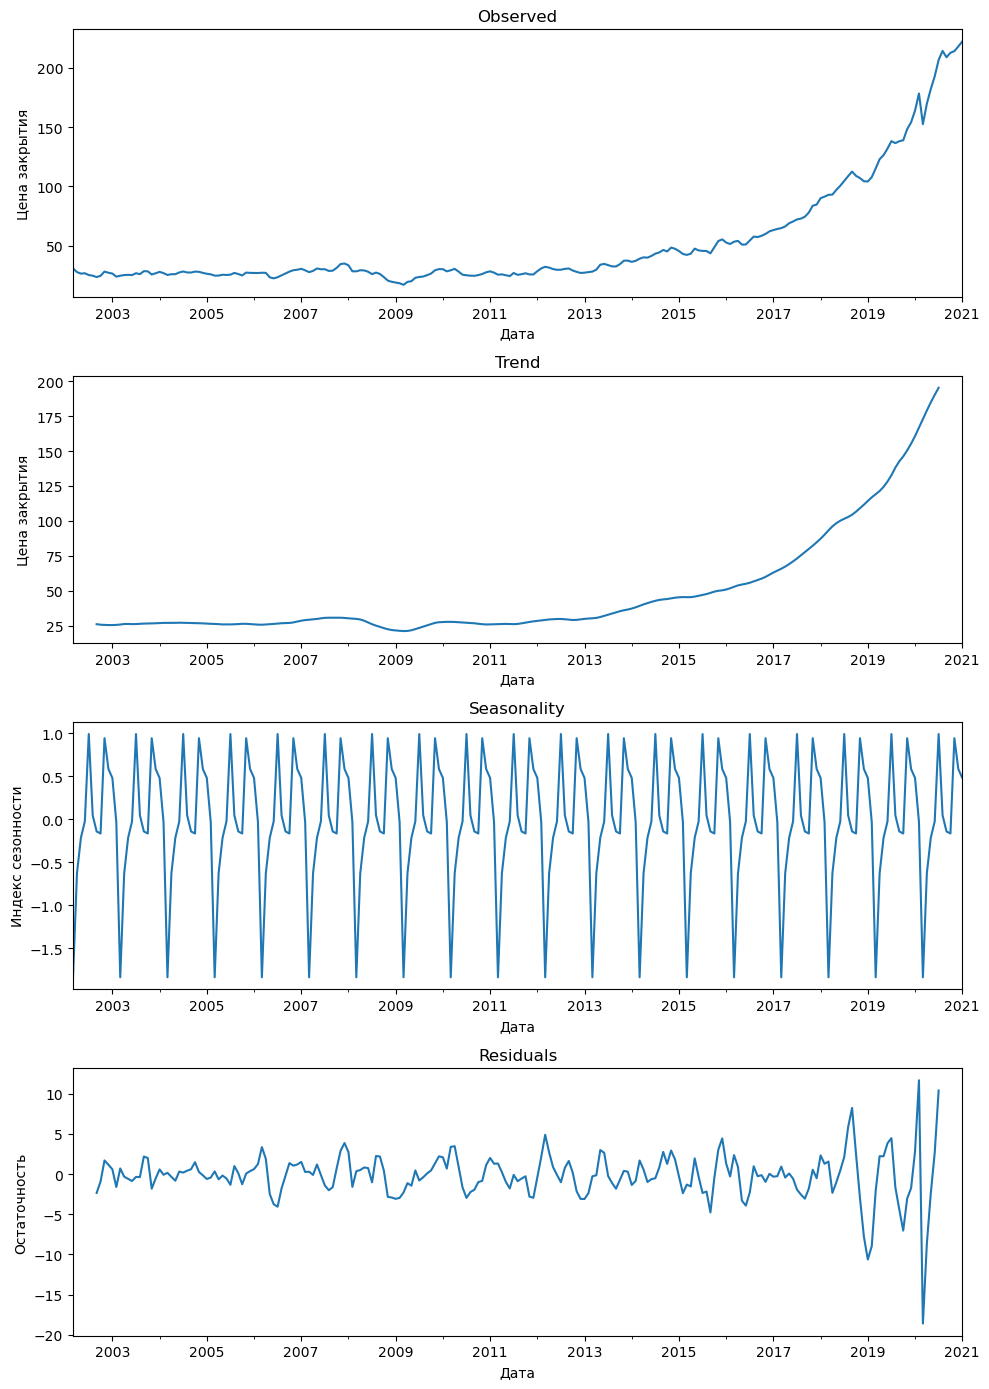

In [24]:
decomposed = seasonal_decompose(df['Close'])
plt.figure(figsize = (10, 14))
plt.subplot(4, 1, 1)
decomposed.observed.plot(ax = plt.gca())
plt.title('Observed')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.subplot(4, 1, 2)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.subplot(4, 1, 3)
decomposed.seasonal['2001-03-31':'2021-01-31'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.xlabel('Дата')
plt.ylabel('Индекс сезонности')
plt.subplot(4, 1, 4)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.xlabel('Дата')
plt.ylabel('Остаточность')
plt.tight_layout()

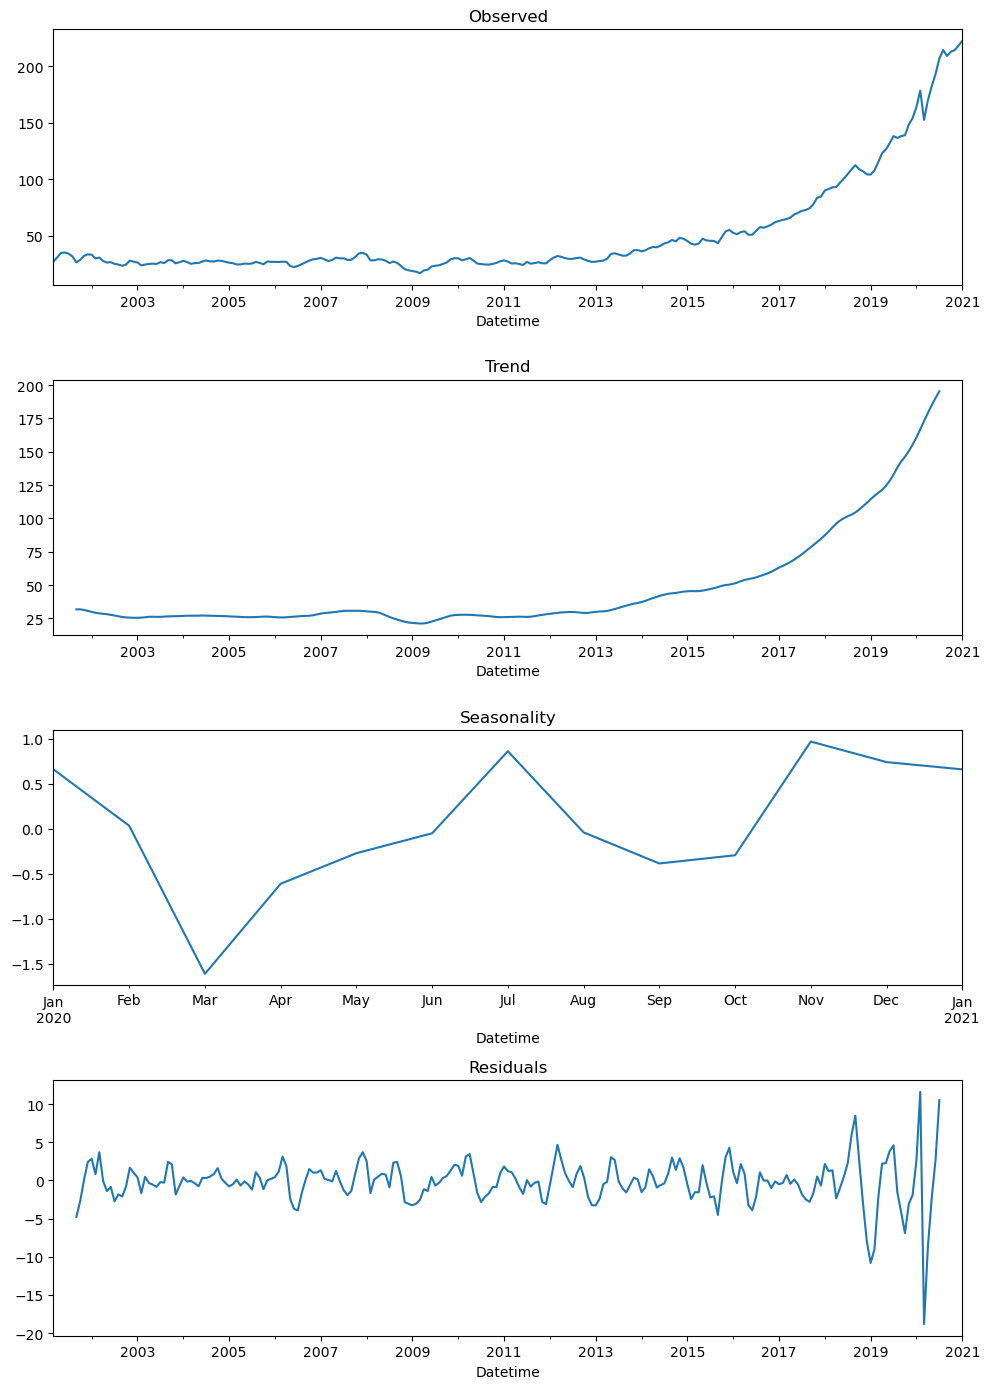

In [10]:
decomposed = seasonal_decompose(df['Close'])
plt.figure(figsize = (10, 14))
plt.subplot(4, 1, 1)
decomposed.observed.plot(ax = plt.gca())
plt.title('Observed')
plt.subplot(4, 1, 2)
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.subplot(4, 1, 3)
decomposed.seasonal['2020-01-31':'2021-01-31'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(4, 1, 4)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['Close'].shift(lag)
        
    data['rolling_mean'] = data['Close'].shift().rolling(rolling_mean_size).mean()
    
    return data

make_features(df, 12, 10)

,Open,High,Low,Close,Volume,year,month,day,lag_1,lag_2,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2001-03-31,27.325000,29.28125,24.87500,27.390625,970665400,2001,3,31,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-30,30.828553,35.50000,25.53125,31.009013,1882887400,2001,4,30,27.390625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-05-31,34.883500,36.07500,33.66500,34.943250,1616017800,2001,5,31,31.009013,27.390625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-30,35.158333,38.07500,33.00500,35.307381,1449177800,2001,6,30,34.943250,31.009013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-07-31,34.260526,36.57500,32.10000,34.144737,1332928400,2001,7,31,35.307381,34.943250,...,27.390625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,209.613128,232.86000,196.25000,208.987294,634429529,2020,9,30,214.344552,206.725701,...,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,138.971430,138.115500,176.331343
2020-10-31,212.809657,225.13000,199.62000,212.812631,498101337,2020,10,31,208.987294,214.344552,...,192.854951,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,138.971430,182.396462
2020-11-30,214.209750,228.12000,200.13000,214.138999,561253167,2020,11,30,212.812631,208.987294,...,206.725701,192.854951,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,188.263830


In [12]:
df = df.dropna()

features = df.drop(['Close'], axis = 1)
target = df['Close']

feat_all, features_test, target_all, target_test = train_test_split(features, target, test_size = 0.1, random_state = 42, shuffle = False)

features_train, features_valid, target_train, target_valid = train_test_split(feat_all, target_all, test_size = 0.16, random_state = 42, shuffle = False)

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.75
--> валидация 0.15
--> тест 0.1


Linear regression error =  0.1779527409784265
Time spent = 0.11 seconds


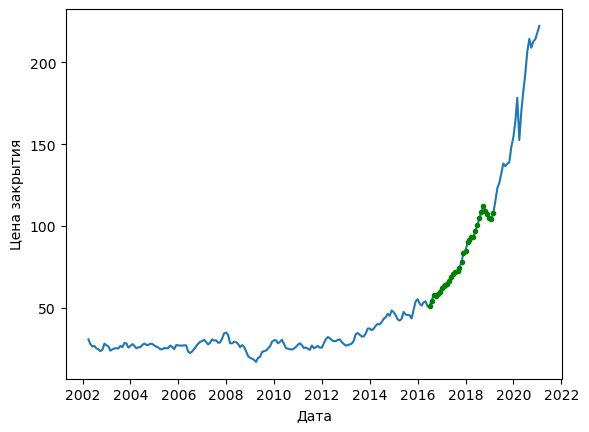

In [13]:
start_time = time.process_time()

regression = LinearRegression()
regression.fit(features_train, target_train)
liner_pred = regression.predict(features_valid)
liner_rmse = mean_squared_error(target_valid, liner_pred)
print('Linear regression error = ', liner_rmse ** 0.5)
print("Time spent = {:.2f}".format(time.process_time() - start_time), "seconds")

plt.plot(df.index, df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
plt.plot(target_valid.index, liner_pred, '.g', label = 'Спрогнозированные данные')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

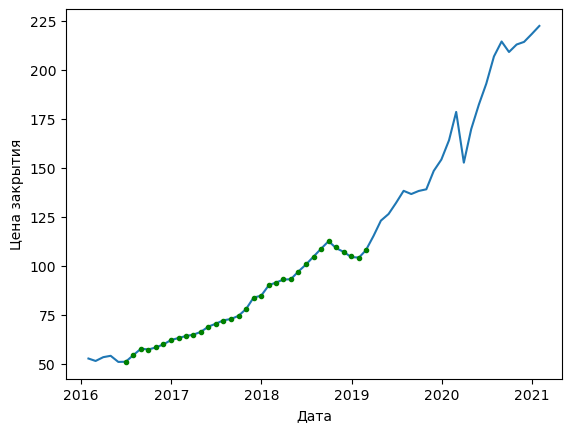

In [14]:
# Создадим фильтр для выборки данных с годом между 2016 и 2021
filter_year = (df['year'].astype(int) >= 2016) & (df['year'].astype(int) <= 2021)

# Применим фильтр к DataFrame для выборки данных, удовлетворяющих условию
filtered_df = df[filter_year]

plt.plot(filtered_df.index, filtered_df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
plt.plot(target_valid.index, liner_pred, '.g', label = 'Спрогнозированные данные')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

Learning rate set to 0.030974
0:	learn: 7.7232554	total: 144ms	remaining: 2m 23s
1:	learn: 7.5571323	total: 146ms	remaining: 1m 12s
2:	learn: 7.3751241	total: 148ms	remaining: 49s
3:	learn: 7.1956723	total: 150ms	remaining: 37.2s
4:	learn: 7.0307514	total: 152ms	remaining: 30.2s
5:	learn: 6.8745898	total: 154ms	remaining: 25.4s
6:	learn: 6.7228364	total: 155ms	remaining: 22s
7:	learn: 6.5626144	total: 158ms	remaining: 19.6s
8:	learn: 6.4188393	total: 160ms	remaining: 17.6s
9:	learn: 6.2780444	total: 161ms	remaining: 16s
10:	learn: 6.1307666	total: 164ms	remaining: 14.8s
11:	learn: 5.9890640	total: 166ms	remaining: 13.7s
12:	learn: 5.8640455	total: 168ms	remaining: 12.7s
13:	learn: 5.7414575	total: 169ms	remaining: 11.9s
14:	learn: 5.6211162	total: 171ms	remaining: 11.2s
15:	learn: 5.5065047	total: 173ms	remaining: 10.6s
16:	learn: 5.3900037	total: 174ms	remaining: 10.1s
17:	learn: 5.2737775	total: 176ms	remaining: 9.6s
18:	learn: 5.1653444	total: 177ms	remaining: 9.16s
19:	learn: 5.049

272:	learn: 0.3351422	total: 587ms	remaining: 1.56s
273:	learn: 0.3347105	total: 589ms	remaining: 1.56s
274:	learn: 0.3340779	total: 590ms	remaining: 1.55s
275:	learn: 0.3332806	total: 592ms	remaining: 1.55s
276:	learn: 0.3304670	total: 593ms	remaining: 1.55s
277:	learn: 0.3281128	total: 594ms	remaining: 1.54s
278:	learn: 0.3276920	total: 596ms	remaining: 1.54s
279:	learn: 0.3253657	total: 597ms	remaining: 1.53s
280:	learn: 0.3247502	total: 599ms	remaining: 1.53s
281:	learn: 0.3243426	total: 601ms	remaining: 1.53s
282:	learn: 0.3220742	total: 602ms	remaining: 1.52s
283:	learn: 0.3199323	total: 604ms	remaining: 1.52s
284:	learn: 0.3177973	total: 606ms	remaining: 1.52s
285:	learn: 0.3160430	total: 608ms	remaining: 1.52s
286:	learn: 0.3149388	total: 610ms	remaining: 1.51s
287:	learn: 0.3137314	total: 611ms	remaining: 1.51s
288:	learn: 0.3133347	total: 613ms	remaining: 1.51s
289:	learn: 0.3127513	total: 614ms	remaining: 1.5s
290:	learn: 0.3121734	total: 615ms	remaining: 1.5s
291:	learn: 0.

516:	learn: 0.1442834	total: 958ms	remaining: 895ms
517:	learn: 0.1438141	total: 960ms	remaining: 893ms
518:	learn: 0.1431180	total: 961ms	remaining: 891ms
519:	learn: 0.1425681	total: 963ms	remaining: 889ms
520:	learn: 0.1420658	total: 965ms	remaining: 887ms
521:	learn: 0.1416464	total: 966ms	remaining: 885ms
522:	learn: 0.1412713	total: 968ms	remaining: 883ms
523:	learn: 0.1405019	total: 969ms	remaining: 880ms
524:	learn: 0.1403255	total: 970ms	remaining: 878ms
525:	learn: 0.1396791	total: 972ms	remaining: 876ms
526:	learn: 0.1394952	total: 974ms	remaining: 874ms
527:	learn: 0.1389120	total: 976ms	remaining: 873ms
528:	learn: 0.1387007	total: 978ms	remaining: 870ms
529:	learn: 0.1381480	total: 979ms	remaining: 868ms
530:	learn: 0.1374676	total: 981ms	remaining: 866ms
531:	learn: 0.1369896	total: 983ms	remaining: 864ms
532:	learn: 0.1364174	total: 984ms	remaining: 862ms
533:	learn: 0.1361707	total: 986ms	remaining: 860ms
534:	learn: 0.1359271	total: 988ms	remaining: 858ms
535:	learn: 

754:	learn: 0.0748254	total: 1.34s	remaining: 436ms
755:	learn: 0.0746612	total: 1.34s	remaining: 434ms
756:	learn: 0.0745907	total: 1.35s	remaining: 432ms
757:	learn: 0.0745228	total: 1.35s	remaining: 430ms
758:	learn: 0.0742557	total: 1.35s	remaining: 429ms
759:	learn: 0.0740156	total: 1.35s	remaining: 427ms
760:	learn: 0.0736781	total: 1.35s	remaining: 425ms
761:	learn: 0.0736114	total: 1.35s	remaining: 423ms
762:	learn: 0.0731442	total: 1.35s	remaining: 421ms
763:	learn: 0.0727690	total: 1.36s	remaining: 419ms
764:	learn: 0.0724765	total: 1.36s	remaining: 417ms
765:	learn: 0.0723164	total: 1.36s	remaining: 416ms
766:	learn: 0.0721985	total: 1.36s	remaining: 414ms
767:	learn: 0.0720535	total: 1.36s	remaining: 412ms
768:	learn: 0.0717722	total: 1.36s	remaining: 410ms
769:	learn: 0.0715824	total: 1.37s	remaining: 408ms
770:	learn: 0.0714671	total: 1.37s	remaining: 406ms
771:	learn: 0.0713246	total: 1.37s	remaining: 404ms
772:	learn: 0.0712227	total: 1.37s	remaining: 403ms
773:	learn: 

Time spent = 16.14 seconds
RMSE of model = 33.91940208906482
16.14 seconds


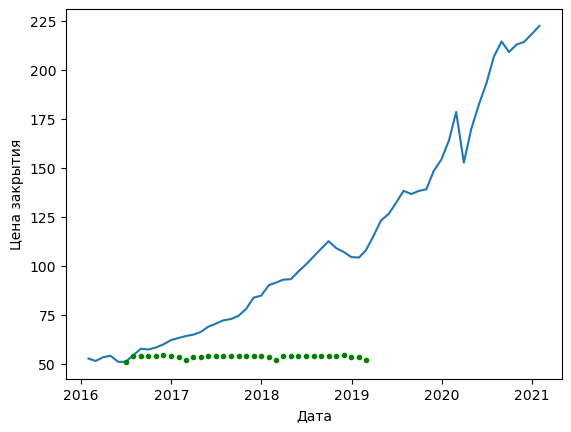

In [15]:
start_time = time.process_time()

train_dataset = cb.Pool(features_train, target_train) 
test_dataset = cb.Pool(features_test, target_test)
valid_dataset = cb.Pool(features_valid, target_valid)
model = cb.CatBoostRegressor(loss_function = 'RMSE')
model.fit(features_train, target_train)
pred = model.predict(features_valid )
print("Time spent = {:.2f}".format(time.process_time() - start_time), "seconds")

rmse = ((mean_squared_error(target_valid, pred)) ** 0.5)
print(f'RMSE of model = {rmse}')
print("{:.2f}".format(time.process_time() - start_time), "seconds")

plt.plot(filtered_df.index, filtered_df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
plt.plot(target_valid.index, pred, '.g', label = 'Спрогнозированные данные')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.show()

Linear Regression error = 0.1779527409784265
Time spent = 0.00 seconds


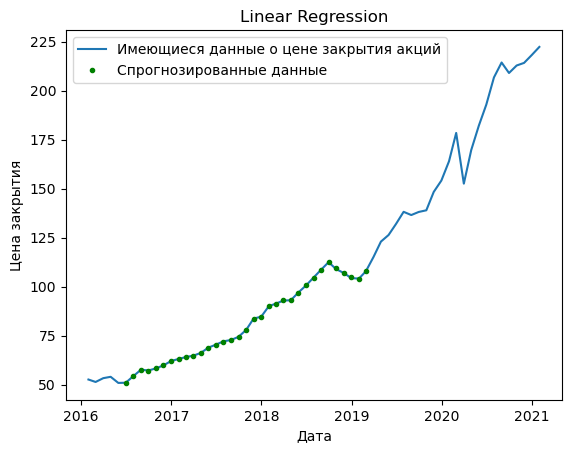

Ridge Regression error = 0.17542755638775834
Time spent = 0.09 seconds


C:\Games\anacondajup\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.21188e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


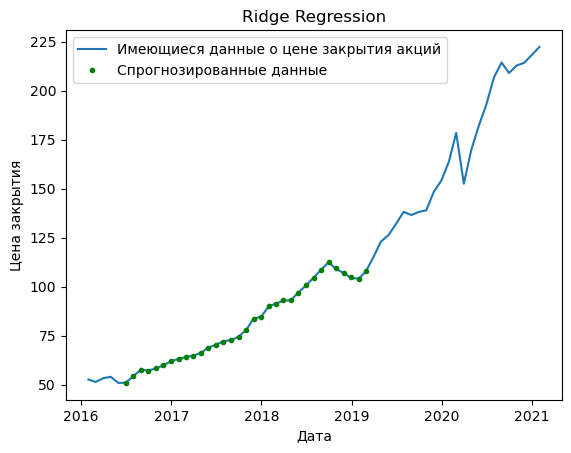

Lasso Regression error = 1.4186538793038113
Time spent = 0.00 seconds


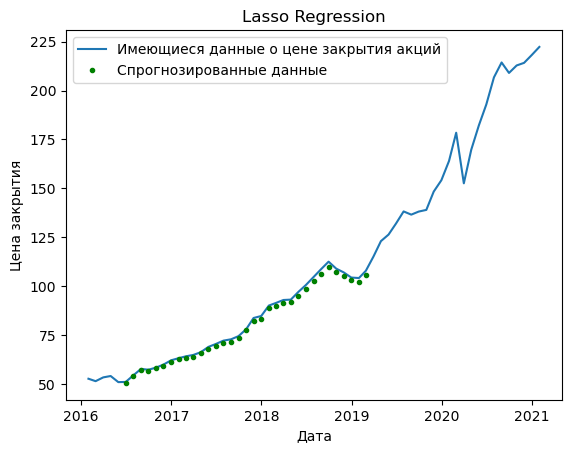

Random Forest error = 34.383470823118664
Time spent = 0.17 seconds


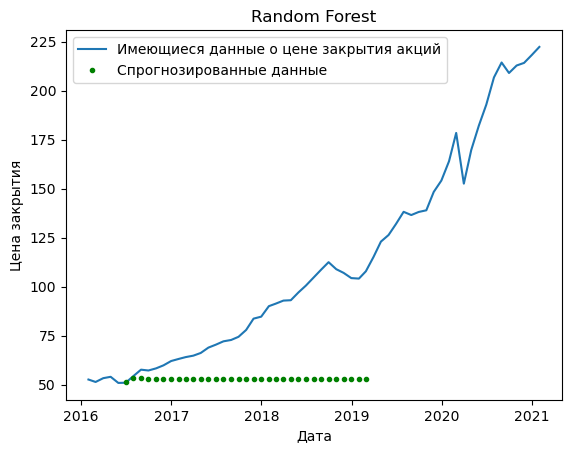

Support Vector Machine error = 50.35017077323628
Time spent = 0.00 seconds


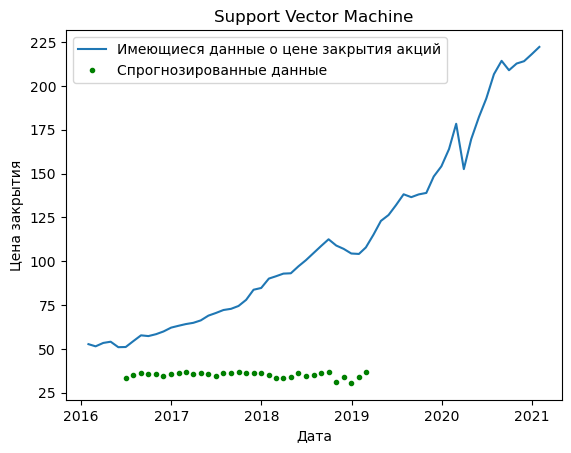

In [16]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machine": SVR()
}


for model_name, model in models.items():
    start_time = time.process_time()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    rmse = (mean_squared_error(target_valid, predictions)) ** 0.5
    print(f"{model_name} error = {rmse}")
    print("Time spent = {:.2f}".format(time.process_time() - start_time), "seconds")
    
    plt.plot(filtered_df.index, filtered_df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
    plt.plot(target_valid.index, predictions, '.g', label = 'Спрогнозированные данные')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.title(model_name)
    plt.legend()
    plt.show()


In [17]:
#РАНЕЕ ДЛЯ ПРОГНОЗИРОВАНИЯ ИСПОЛЬЗОВАЛИСЬ ВСЕ ДАННЫЕ, ВКЛЮЧАЯ ЦЕНУ ОТКРЫТИЯ И Т.Д., ТЕПЕРЬ ИСПОЛЬЗУЕМ ТОЛЬКО ЛАГИ И СКОЛЬЗЯЩЕЕ СРЕДНЕЕ

In [18]:
df

,Open,High,Low,Close,Volume,year,month,day,lag_1,lag_2,...,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-03-31,30.780556,32.35000,29.155,30.815833,967410400,2002,3,31,30.000263,33.312105,...,32.314474,28.755263,26.587308,31.733250,34.144737,35.307381,34.943250,31.009013,27.390625,32.081831
2002-04-30,27.909545,30.20000,25.720,27.760227,1417479400,2002,4,30,30.815833,30.000263,...,33.720278,32.314474,28.755263,26.587308,31.733250,34.144737,35.307381,34.943250,31.009013,31.669089
2002-05-31,26.421750,28.22000,24.175,26.424500,1285518200,2002,5,31,27.760227,30.815833,...,33.312105,33.720278,32.314474,28.755263,26.587308,31.733250,34.144737,35.307381,34.943250,30.914374
2002-06-30,26.500833,28.14500,24.585,26.748611,1651578000,2002,6,30,26.424500,27.760227,...,30.000263,33.312105,33.720278,32.314474,28.755263,26.587308,31.733250,34.144737,35.307381,30.142350
2002-07-31,25.219750,27.46500,20.705,25.214250,2088706800,2002,7,31,26.748611,26.424500,...,30.815833,30.000263,33.312105,33.720278,32.314474,28.755263,26.587308,31.733250,34.144737,29.643886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-30,209.613128,232.86000,196.250,208.987294,634429529,2020,9,30,214.344552,206.725701,...,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,138.971430,138.115500,176.331343
2020-10-31,212.809657,225.13000,199.620,212.812631,498101337,2020,10,31,208.987294,214.344552,...,192.854951,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,138.971430,182.396462
2020-11-30,214.209750,228.12000,200.130,214.138999,561253167,2020,11,30,212.812631,208.987294,...,206.725701,192.854951,182.219473,169.708334,152.554092,178.432223,163.999047,154.138949,148.336113,188.263830


In [19]:
features2 = df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis = 1)
target2 = df['Close']

feat_all2, features_test2, target_all2, target_test2 = train_test_split(features2, target2, test_size = 0.1, random_state = 42, shuffle = False)

features_train2, features_valid2, target_train2, target_valid2 = train_test_split(feat_all2, target_all2, test_size = 0.16, random_state = 42, shuffle = False)

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.75
--> валидация 0.15
--> тест 0.1


Linear Regression error = 3.1698194084063225
Time spent = 0.09 seconds


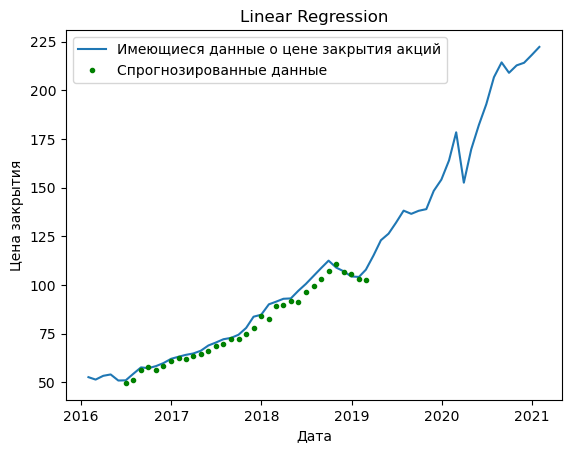

Ridge Regression error = 3.174672088677653
Time spent = 0.00 seconds


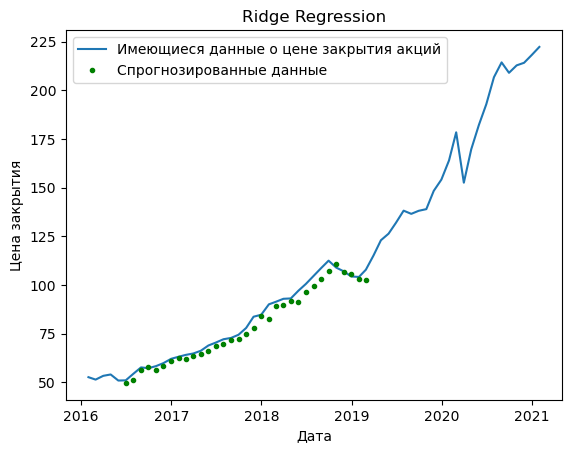

Lasso Regression error = 3.3734272415639395
Time spent = 0.00 seconds


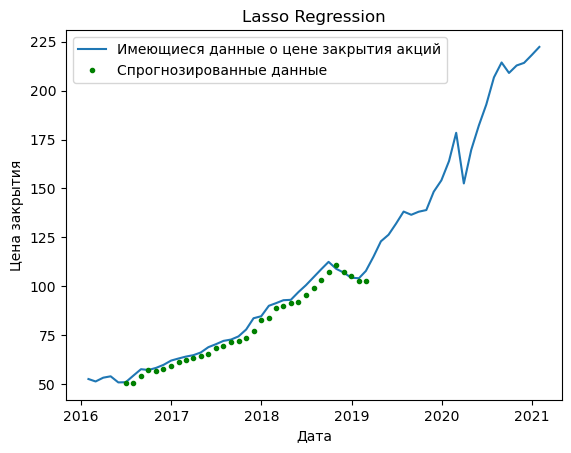

Random Forest error = 34.9943020731028
Time spent = 0.17 seconds


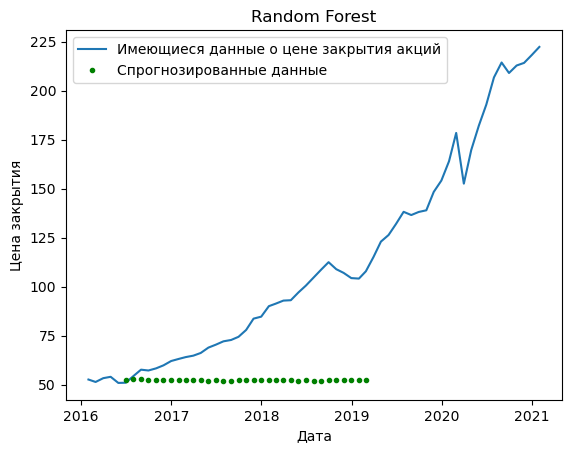

Support Vector Machine error = 56.804655628489186
Time spent = 0.00 seconds


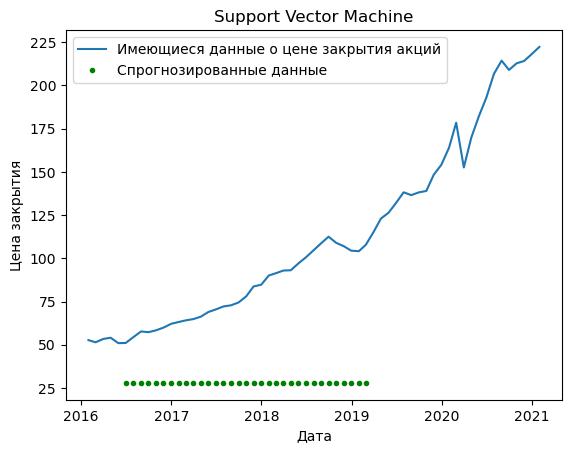

In [20]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Support Vector Machine": SVR()
}


for model_name, model in models.items():
    start_time = time.process_time()
    model.fit(features_train2, target_train2)
    predictions = model.predict(features_valid2)
    rmse = (mean_squared_error(target_valid2, predictions)) ** 0.5
    print(f"{model_name} error = {rmse}")
    print("Time spent = {:.2f}".format(time.process_time() - start_time), "seconds")
    
    plt.plot(filtered_df.index, filtered_df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
    plt.plot(target_valid2.index, predictions, '.g', label = 'Спрогнозированные данные')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.title(model_name)
    plt.legend()
    plt.show()


In [21]:
#РАНЕЕ ДЛЯ ПРОГНОЗИРОВАНИЯ ИСПОЛЬЗОВАЛИСЬ ВСЕ ДАННЫЕ, ВКЛЮЧАЯ ЦЕНУ ОТКРЫТИЯ И Т.Д., ТЕПЕРЬ ИСПОЛЬЗУЕМ ТОЛЬКО ЛАГИ

In [22]:
features3 = df.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'rolling_mean'], axis = 1)
target3 = df['Close']

feat_all3, features_test3, target_all3, target_test3 = train_test_split(features3, target3, test_size = 0.1, random_state = 42, shuffle = False)

features_train3, features_valid3, target_train3, target_valid3 = train_test_split(feat_all3, target_all3, test_size = 0.16, random_state = 42, shuffle = False)

print('Соотношение:')
print('--> тренировка', round(features_train.shape[0] / df.shape[0], 2))
print('--> валидация', round(features_valid.shape[0] / df.shape[0], 2))
print('--> тест', round(features_test.shape[0] / df.shape[0], 2))

Соотношение:
--> тренировка 0.75
--> валидация 0.15
--> тест 0.1


Linear Regression error = 3.169819408406034
Time spent = 0.03 seconds


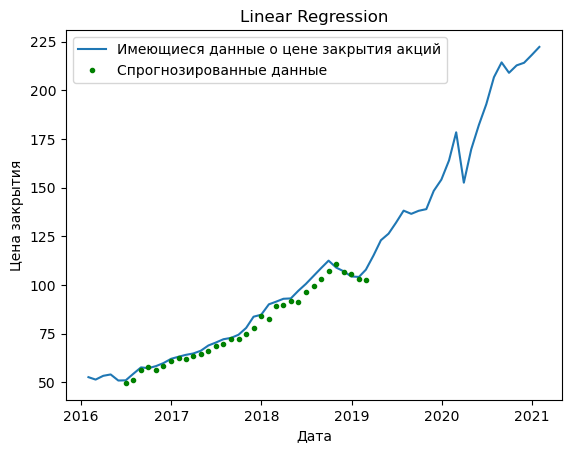

Ridge Regression error = 3.174729943207983
Time spent = 0.00 seconds


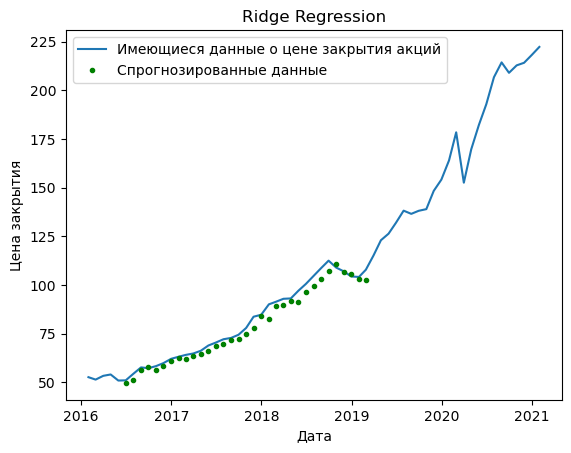

Lasso Regression error = 3.3734272415639395
Time spent = 0.00 seconds


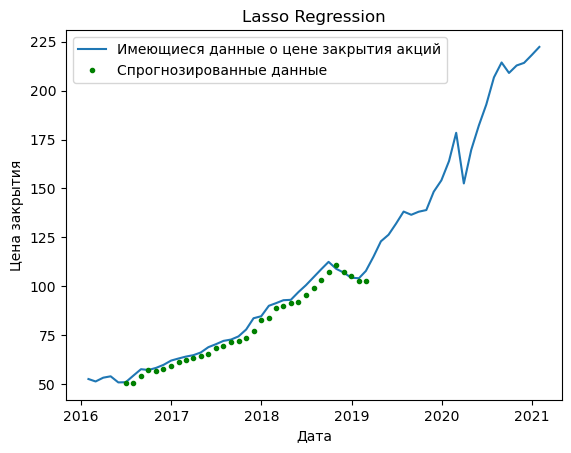

Random Forest error = 34.907016329487455
Time spent = 0.17 seconds


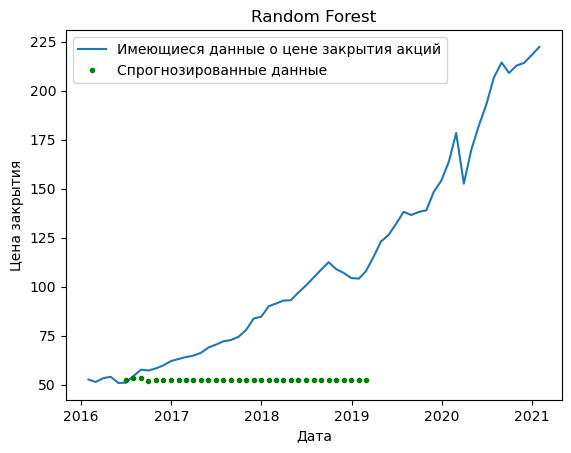

Support Vector Machine error = 56.81787278204419
Time spent = 0.02 seconds


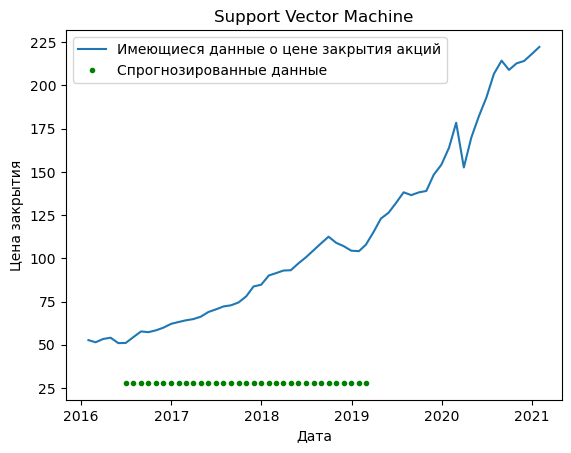

In [23]:
for model_name, model in models.items():
    start_time = time.process_time()
    model.fit(features_train3, target_train3)
    predictions = model.predict(features_valid3)
    rmse = (mean_squared_error(target_valid3, predictions)) ** 0.5
    print(f"{model_name} error = {rmse}")
    print("Time spent = {:.2f}".format(time.process_time() - start_time), "seconds")
    
    plt.plot(filtered_df.index, filtered_df['Close'], label = 'Имеющиеся данные о цене закрытия акций')
    plt.plot(target_valid3.index, predictions, '.g', label = 'Спрогнозированные данные')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.title(model_name)
    plt.legend()
    plt.show()
